In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('E:/ImagePara/data/allData.xlsx', sheet_name='150data')

In [3]:
def params(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return mu, sigma

def transport(data, mu, sigma):
    return (data - mu) / sigma

def inverse(data, mu, sigma):
    return data * sigma + mu

In [4]:
batch_size = train_nums = int(data.shape[0] * 80/100)

input_data, output_data = data.iloc[:, :4], data.iloc[:, 4:]

# only standardlaize inputdata for the outputdata were gathered
X_mu, X_sigma = params(input_data[:train_nums].values)

z_inputdata = transport(input_data.values, X_mu, X_sigma)

train_data = torch.tensor(z_inputdata[:train_nums], dtype=torch.float)
test_data  = torch.tensor(z_inputdata[train_nums:], dtype=torch.float)
train_target = torch.tensor(output_data[:train_nums].values, dtype=torch.float)
test_target  = torch.tensor(output_data[train_nums:].values, dtype=torch.float)

# create the data loaders 
trainset = torch.utils.data.TensorDataset(train_data, train_target)
testset = torch.utils.data.TensorDataset(test_data, test_target)
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=1, shuffle=False)

print("trainData lenth:", train_nums, "\ntestData lenth:", data.shape[0]-train_nums)

trainData lenth: 120 
testData lenth: 30


In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden1_size, bias=True)    # 线性变换
        self.layer2 = nn.Linear(hidden1_size, hidden2_size, bias=True)  # 线性变换
        self.layer3 = nn.Linear(hidden2_size, hidden3_size, bias=True)  # 线性变换
        self.outlayer = nn.Linear(hidden3_size, output_size, bias=True) # 线性变换
        
    def forward(self,x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        out = self.outlayer(x)
        return out

In [6]:
net = Net(4, 10, 20, 10, 3)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss_func = nn.MSELoss()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, mean=0, std=1)
        nn.init.constant_(m.bias, 0.0)

net.apply(weights_init)

print("Total number of paramerters in networks is {}.".format(sum(x.numel() for x in net.parameters())))
print(net)

Total number of paramerters in networks is 513.
Net(
  (layer1): Linear(in_features=4, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=10, bias=True)
  (outlayer): Linear(in_features=10, out_features=3, bias=True)
)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.88it/s]


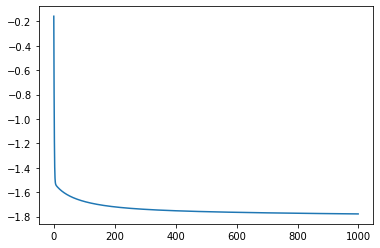

In [7]:
# train
num_epochs = 1000
train_loss = []
for epoch in tqdm(range(num_epochs)):
    for datas, targets in train_loader:
        targets = targets.view(batch_size, -1)
        optimizer.zero_grad()
        outputs = net(datas)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())

plt.plot(np.log10(train_loss))
plt.show()

In [8]:
# test
prediction = []
test_loss = []
for datas, targets in test_loader:
    targets = targets.view(1, -1)
    outputs = net(datas)
    loss = loss_func(outputs, targets)
    prediction.append(outputs.tolist()[0])
    test_loss.append(loss.item())

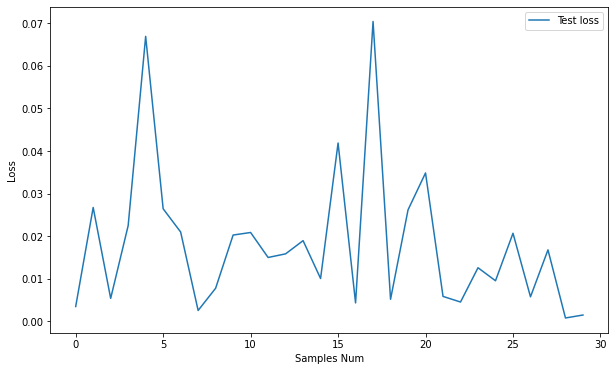

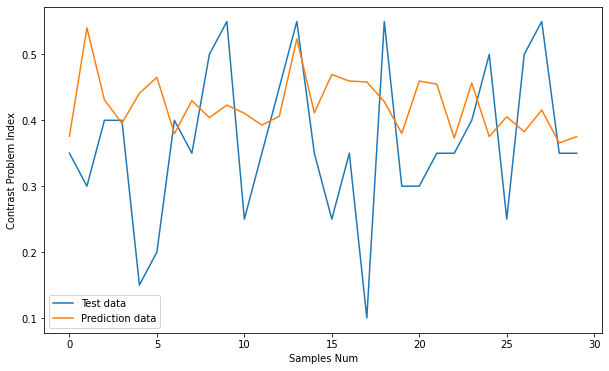

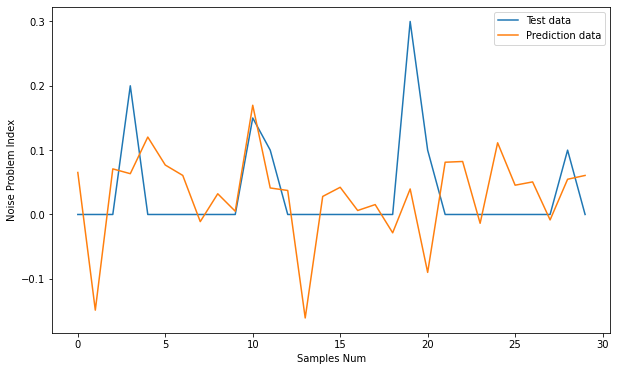

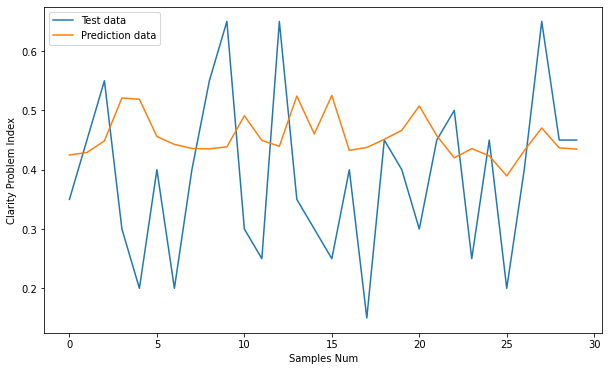

In [9]:
plt.figure(figsize=(10,6))
plt.plot(test_loss)
plt.legend(["Test loss"])
plt.xlabel("Samples Num")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(test_target[:,0])
plt.plot(np.array(prediction)[:,0])
plt.legend(["Test data", "Prediction data"])
plt.xlabel("Samples Num")
plt.ylabel("Contrast Problem Index")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(test_target[:,1])
plt.plot(np.array(prediction)[:,1])
plt.legend(["Test data", "Prediction data"])
plt.xlabel("Samples Num")
plt.ylabel("Noise Problem Index")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(test_target[:,2])
plt.plot(np.array(prediction)[:,2])
plt.legend(["Test data", "Prediction data"])
plt.xlabel("Samples Num")
plt.ylabel("Clarity Problem Index")
plt.show()